In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt

import jaxley as jx
from jaxley.channels.channel import Channel
from jaxley.solver_gate import solve_inf_gate_exponential

from jaxley_mech.synapses import AMPA
from jaxley_mech.channels.hh import Leak, Na, K

## AMPA

In [2]:
comp = jx.Compartment()
comp.set("length", 10)
comp.set("radius", 5)
comp.set("v", -70)

comp.insert(Leak())
comp.set("Leak_gLeak", 1/5000)
comp.set("Leak_eLeak", -70)

def m_gate(v):
    v -= -63
    alpha_m = 0.32 * (13 - v) / (jnp.exp(13-v)/4 - 1)
    beta_m = 0.28 * (v - 40) / (jnp.exp((v-40)/5) - 1)
    return alpha_m, beta_m

def h_gate(v):
    v -= -63
    alpha_h = 0.128 * jnp.exp((17 - v)/18)
    beta_h = 4 / (jnp.exp((40-v)/5) + 1)
    return alpha_h, beta_h


def n_gate(v):
    v -= -63
    alpha_n = 0.032 * (15 - v) / (jnp.exp(15-v)/5 - 1)
    beta_n = 0.5 * jnp.exp((10-v)/40)
    return alpha_n, beta_n

na = Na()
k = K()
na.m_gate = m_gate
na.h_gate = h_gate
k.n_gate = n_gate

comp.insert(na)
comp.set("Na_gNa", 0.1)
comp.set("Na_eNa", 50)

comp.insert(k)
comp.set("K_gK", 0.03)
comp.set("K_eK", -90)

branch = jx.Branch(comp, 1)
cell = jx.Cell(branch, parents=[-1])
net = jx.Network([cell for _ in range(2)])

pre = net.cell(0).branch(0).comp(0.5)
post = net.cell(1).branch(0).comp(0.5)

pre.connect(post, AMPA(name="AMPA"))

/Users/ziweih/Works/retimod/jaxley/jaxley/modules/compartment.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


In [3]:
# Stimulus.
i_delay = 1.  # ms
i_amp = 0.1  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 40.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

# stimulate the pre-synaptic compartment
currents = [
    jx.step_current(i_delay, i_dur, i_amp, dt, t_max),
    jnp.hstack([jx.step_current(i_delay, i_dur, i_amp, dt, 3)[:-1] for _ in range(4)] + [jx.step_current(i_delay, 20, 0, dt, t_max - 3 * 4)])
]
res = []
from copy import deepcopy
for current in currents:
    net0 = deepcopy(net)
    net0.cell(0).branch(0).comp(0.0).stimulate(current)

    # record the membrane potential of the pre- and post-synaptic compartments
    net0.cell(0).branch(0).comp(0.5).record()
    net0.cell(1).branch(0).comp(0.5).record()

    net0.cell(1).branch(0).comp(0.5).record("AMPA_R")
    net0.cell(1).branch(0).comp(0.5).record("AMPA_C")

    s = jx.integrate(net0, delta_t=dt)
    res.append(s)


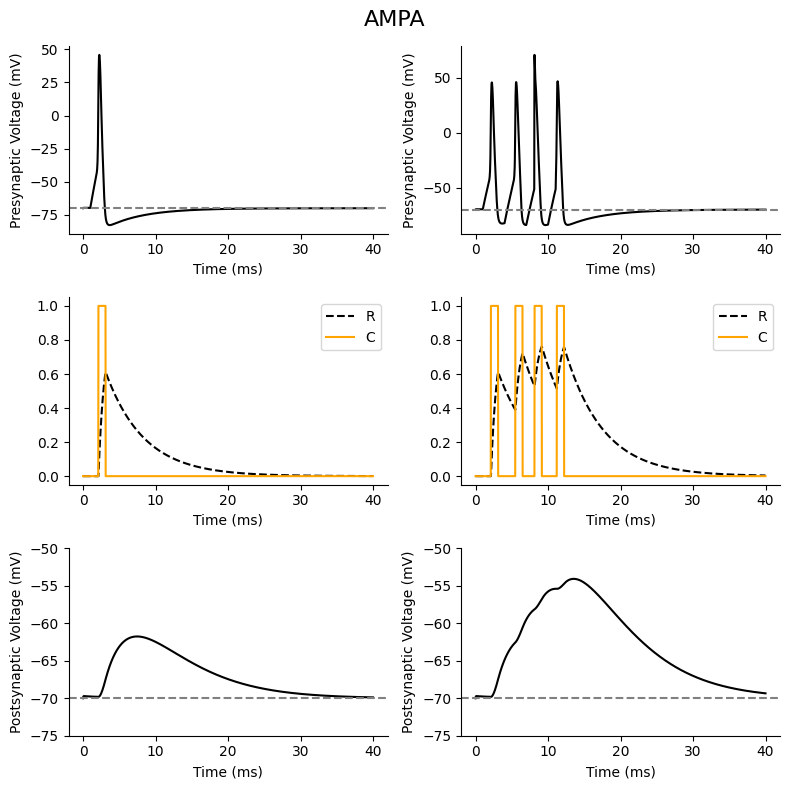

In [4]:
fig, ax = plt.subplot_mosaic([['PRE0', 'PRE1'], ['U0', "U1"], ['POST0', "POST1"]], figsize=(8,8))

for i in range(2):
    ax[f"PRE{i}"].plot(time_vec, res[i][0].T[:-1], color="black")
    ax[f"PRE{i}"].set_xlabel("Time (ms)")
    ax[f"PRE{i}"].set_ylabel("Presynaptic Voltage (mV)")
    ax[f"PRE{i}"].axhline(-70, color="gray", linestyle="--")

    ax[f"U{i}"].plot(time_vec, res[i][2].T[:-1], label="R", color='black', linestyle="--")
    ax[f"U{i}"].plot(time_vec, res[i][3].T[:-1], label="C", color='orange')
    ax[f"U{i}"].set_xlabel("Time (ms)")
    ax[f"U{i}"].legend()

    ax[f"POST{i}"].plot(time_vec, res[i][1].T[:-1], color="black")
    ax[f"POST{i}"].set_xlabel("Time (ms)")
    ax[f"POST{i}"].set_ylabel("Postsynaptic Voltage (mV)")
    ax[f"POST{i}"].axhline(-70, color="gray", linestyle="--")
    ax[f"POST{i}"].set_ylim(-75, -50)

    for a in ax.values():
        a.spines[['top', 'right']].set_visible(False)

    fig.tight_layout()
    fig.suptitle("AMPA", fontsize=16)